# Alignment

The goal of this notebook is to align files using DTW, weakly-ordered Segmental DTW, or strictly-ordered Segmental DTW.

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc

### Align with DTW

The following cell contains a cython implementation of basic DTW.

In [3]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    cdef np.int32_t startCol # added
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0
    
    # added START
    if 'startCol' in parameter.keys(): 
        startCol = parameter['startCol']
    else:
        startCol = -1
    # added END

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1
        
    # added - if specified, overrides above
    if startCol >= 0:
        curCol = startCol

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [4]:
def alignDTW(featfile1, featfile2, steps, weights, downsample, outfile = None, profile = False):
    
    F1 = np.load(featfile1) # 12 x N
    F2 = np.load(featfile2) # 12 x M
    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        if outfile:
            pickle.dump(None, open(outfile, 'wb'))
        return None
    times = []
    times.append(time.time())
    C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
    times.append(time.time())

    dn = steps[:,0].astype(np.uint32)
    dm = steps[:,1].astype(np.uint32)
    parameters = {'dn': dn, 'dm': dm, 'dw': weights, 'SubSequence': False}
    [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameters)
    times.append(time.time())
    [wp, endCol, endCost] = DTW_GetPath(D, s, parameters)
    times.append(time.time())
    if outfile:
        pickle.dump(wp, open(outfile, 'wb'))
    
    if profile:
        return wp, np.diff(times)
    else:
        return wp

In [5]:
def alignDTW_batch(querylist, featdir1, featdir2, outdir, n_cores, steps, weights, downsample):
    
    outdir.mkdir(parents=True, exist_ok=True)
    
    # prep inputs for parallelization
    inputs = []
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            featfile1 = (featdir1 / parts[0]).with_suffix('.npy')
            featfile2 = (featdir2 / parts[1]).with_suffix('.npy')
            queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            outfile = (outdir / queryid).with_suffix('.pkl')
            if os.path.exists(outfile):
                print(f"Skipping {outfile}")
            else:
                inputs.append((featfile1, featfile2, steps, weights, downsample, outfile))

    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(alignDTW, inputs)
    
    return

Align a single pair of audio files

In [6]:
featfile1 = 'features/clean/Chopin_Op068No3/Chopin_Op068No3_Tomsic-1995_pid9190-11.npy'
featfile2 = 'features/clean/Chopin_Op068No3/Chopin_Op068No3_Cortot-1951_pid9066b-19.npy'
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
wp = alignDTW(featfile1, featfile2, steps, weights, downsample)

Align all pairs of audio files

In [7]:
query_list = 'cfg_files/query.test.list'
featdir1 = Path('features/clean')
featdir2 = Path('features/clean') # in case you want to align clean vs noisy
outdir = Path('experiments_test/dtw_clean')
n_cores = 24
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
inputs = alignDTW_batch(query_list, featdir1, featdir2, outdir, n_cores, steps, weights, downsample)

Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ax-1985_pid9179-07.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Bacha-1998_pid9166e-08.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Barbosa-1983_pid9174-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ben-Or-1989_pid9161-13.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Biret-1990_pid9062-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Brailowsky-1960_pid9060-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Chiu-1999_pid9048-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Clidat-1994_pid9067-15.pkl
Skipping experiments_test/

### Align with WSDTW

Align with weakly-ordered Segmental DTW.

In [8]:
# def alignWSDTW(featfile1, featfile2, steps, weights, downsample, numSegments, outfile = None, profile = False):
    
#     # compute cost matrix
#     F1 = np.load(featfile1) # 12 x N
#     F2 = np.load(featfile2) # 12 x M
#     if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
#         if outfile:
#             pickle.dump(None, open(outfile, 'wb'))
#         return None
#     times = []
#     times.append(time.time())
#     C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
#     times.append(time.time())

#     # run subseqDTW on chunks
#     seglen = int(np.ceil(C.shape[0] / numSegments))
#     dn1 = steps[:,0].astype(np.uint32)
#     dm1 = steps[:,1].astype(np.uint32)
#     dw1 = weights
#     params1 = {'dn': dn1, 'dm': dm1, 'dw': dw1, 'SubSequence': True}
#     Dparts = []
#     Bparts = []
#     for i in range(numSegments):
#         Cpart = C[i*seglen : min((i+1)*seglen, C.shape[0]), :]
#         [D, B] = DTW_Cost_To_AccumCostAndSteps(Cpart, params1)
#         Dparts.append(D)
#         Bparts.append(B)
#     times.append(time.time())

#     # run segment-level DP
#     Cseg = np.zeros((numSegments+1, C.shape[1]))
#     for i in range(len(Dparts)):
#         Cseg[i+1,:] = Dparts[i][-1,:]
#     dn2 = np.array([0, 1], dtype=np.uint32)
#     dm2 = np.array([1, seglen//np.max(steps[:,0])], dtype=np.uint32)
#     dw2 = np.array([0, 1])
#     params2 = {'dn': dn2, 'dm': dm2, 'dw': dw2, 'SubSequence': False}
#     [Dseg, Bseg] = DTW_Cost_To_AccumCostAndSteps(Cseg, params2)
#     times.append(time.time())
#     [wpseg, _, _] = DTW_GetPath(Dseg, Bseg, params2)

#     # backtrace
#     segmentEndIdxs = getSegmentEndingLocs(wpseg)
#     times.append(time.time())
#     wps = []
#     for i, endidx in enumerate(segmentEndIdxs):
#         params3 = {'dn': dn1, 'dm': dm1, 'dw': dw1, 'SubSequence': True, 'startCol': endidx}
#         [wpchunk, _, _] = DTW_GetPath(Dparts[i], Bparts[i], params3)
#         wpchunk[0,:] = wpchunk[0,:] + i*seglen  # account for relative offset
#         wps.append(wpchunk.copy())
#     wp_merged = np.hstack(wps)
#     times.append(time.time())

#     if outfile:
#         pickle.dump(wp_merged, open(outfile, 'wb'))

#     if profile:
#         return wp_merged, np.diff(times)
#     else:
#         return wp_merged

In [9]:
# def getSegmentEndingLocs(wp):
#     prevLoc = wp[:,0] # [r,c]
#     endLocs = []
#     for i in range(wp.shape[1]):
#         curLoc = wp[:,i]
#         if curLoc[0] != prevLoc[0]: # if row changes
#             endLocs.append(curLoc[1])
#         prevLoc = curLoc
        
#     return endLocs

In [10]:
# def alignSegmentalDTW_batch(querylist, featdir1, featdir2, outdir, n_cores, steps, weights, downsample, numSegments, fn):

#     outdir.mkdir(parents=True, exist_ok=True)
    
#     # prep inputs for parallelization
#     inputs = []
#     with open(querylist, 'r') as f:
#         for line in f:
#             parts = line.strip().split(' ')
#             assert len(parts) == 2
#             featfile1 = (featdir1 / parts[0]).with_suffix('.npy')
#             featfile2 = (featdir2 / parts[1]).with_suffix('.npy')
#             queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
#             outfile = (outdir / queryid).with_suffix('.pkl')
#             if os.path.exists(outfile):
#                 print(f"Skipping {outfile}")
#             else:
#                 inputs.append((featfile1, featfile2, steps, weights, downsample, numSegments, outfile))

#     # process files in parallel
#     pool = multiprocessing.Pool(processes = n_cores)
#     pool.starmap(fn, inputs)

#     return

Align a single pair of audio files

In [11]:
# featfile1 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Afanassiev-2001_pid9130-01.npy'
# featfile2 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Ben-Or-1989_pid9161-12.npy'
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# numSegments = 5
# # wp = alignWSDTW(featfile1, featfile2, steps, weights, downsample, numSegments)

Align all pairs of audio files

In [12]:
# query_list = 'cfg_files/query.test.list'
# featdir1 = Path('features/clean')
# featdir2 = Path('features/clean') # in case you want to align clean vs noisy
# n_cores = 1
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# segmentVals = [2, 4, 8, 16, 32] 
# for numSegments in segmentVals:
#     outdir = Path(f'experiments_test/wsdtw_{numSegments}_clean')
#     alignSegmentalDTW_batch(query_list, featdir1, featdir2, outdir, n_cores, steps, weights, downsample, numSegments, alignWSDTW)

### Align with SSDTW

Align with strictly-ordered Segmental DTW

In [13]:
# %%cython
# import numpy as np
# cimport numpy as np
# cimport cython

# import sys
# import time


# DTYPE_INT32 = np.int32
# ctypedef np.int32_t DTYPE_INT32_t

# DTYPE_FLOAT = np.float64
# ctypedef np.float64_t DTYPE_FLOAT_t

# cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# # careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def Segment_DP(np.ndarray[DTYPE_FLOAT_t, ndim=2] C, np.ndarray[np.int32_t, ndim=2] T):

#     cdef DTYPE_INT32_t numRows = C.shape[0]
#     cdef DTYPE_INT32_t numCols = C.shape[1]    
#     cdef np.ndarray[np.int32_t, ndim=2] steps = np.zeros((numRows+1,numCols), dtype=np.int32)
#     cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((numRows+1, numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

#     cdef unsigned int row, col
#     cdef DTYPE_FLOAT_t skipCost
#     cdef np.int32_t jumpStartCol
#     cdef DTYPE_FLOAT_t jumpCost

#     # initialize
#     for row in range(numRows+1):
#         for col in range(numCols):
#             steps[row, col] = -1 # skip by default
#     for col in range(numCols):
#         accumCost[0, col] = 0 # all inf except first row
        
#     # dynamic programming
#     for row in range(1, numRows+1):
#         for col in range(numCols):
            
#             # skip transition
#             if col == 0:
#                 skipCost = MAX_FLOAT
#             else:
#                 skipCost = accumCost[row, col-1]
#             accumCost[row, col] = skipCost
#             # best step is skip by default, so don't need to assign
            
#             # jump transition
#             jumpStartCol = T[row-1, col]
#             if jumpStartCol >= 0: # valid subsequence path
#                 jumpCost = accumCost[row-1, jumpStartCol] + C[row-1, col]
#                 if jumpCost < skipCost:
#                     accumCost[row, col] = jumpCost
#                     steps[row, col] = jumpStartCol

#     return [accumCost, steps]

# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def Segment_Backtrace(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.int32_t, ndim=2] steps):

#     cdef np.uint32_t numRows = accumCost.shape[0]
#     cdef np.uint32_t numCols = accumCost.shape[1]
#     cdef np.uint32_t curRow = numRows - 1
#     cdef np.uint32_t curCol = numCols - 1
#     cdef np.int32_t jump
#     cdef np.ndarray[np.uint32_t, ndim=1] path = np.zeros(numRows-1, dtype=np.uint32)
#     cdef np.uint32_t pathElems = 0

#     while curRow > 0:
#         if accumCost[curRow, curCol] == MAX_FLOAT:
#             print('A path is not possible')
#             break

#         jump = steps[curRow, curCol]
#         if jump < 0: # skip
#             curCol = curCol - 1
#         else: # jump
#             path[pathElems] = curCol
#             pathElems = pathElems + 1
#             curRow = curRow - 1
#             curCol = jump

#     return path[::-1]

# @cython.boundscheck(False) # turn off bounds-checking for entire function
# def calc_Tseg(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
#     '''

#     Parameter should have: 'dn', 'dm'
#     '''

#     cdef np.ndarray[unsigned int, ndim=1] dn
#     cdef np.ndarray[unsigned int, ndim=1] dm
#     cdef np.uint32_t numRows = accumCost.shape[0]
#     cdef np.uint32_t numCols = accumCost.shape[1]
#     cdef np.ndarray[np.int32_t, ndim=1] startLocs = np.zeros(numCols, dtype=np.int32)
#     cdef np.uint32_t endCol
#     cdef np.uint32_t curRow
#     cdef np.uint32_t curCol
#     cdef np.uint32_t curStepIndex

#     # get step transitions
#     if ('dn'  in parameter.keys()):
#         dn = parameter['dn']
#     else:
#         dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
#     if 'dm'  in parameter.keys():
#         dm = parameter['dm']
#     else:
#         dm = np.array([1, 0, 1], dtype=DTYPE_INT32)

#     # backtrace from every location
#     for endCol in range(numCols):
#         curCol = endCol
#         curRow = numRows - 1
#         while curRow > 0:
#             if accumCost[curRow, curCol] == MAX_FLOAT: # no valid path
#                 startLocs[curCol] = -1
#                 break

#             curStepIndex = stepsForCost[curRow, curCol]
#             curRow = curRow - dn[curStepIndex]
#             curCol = curCol - dm[curStepIndex]
#             if curRow == 0:
#                 startLocs[endCol] = curCol
                
#     return startLocs

# class bcolors:
#     HEADER = '\033[95m'
#     OKBLUE = '\033[94m'
#     OKGREEN = '\033[92m'
#     WARNING = '\033[93m'
#     FAIL = '\033[91m'
#     ENDC = '\033[0m'
#     BOLD = '\033[1m'
#     UNDERLINE = '\033[4m'

In [14]:
# def alignSSDTW(featfile1, featfile2, steps, weights, downsample, numSegments, outfile = None, profile = False):
    
#     # compute cost matrix
#     F1 = np.load(featfile1) # 12 x N
#     F2 = np.load(featfile2) # 12 x M
#     swap = (F1.shape[1] > F2.shape[1])
#     if swap:
#         F1, F2 = F2, F1 # make the shorter sequence the query
#     if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
#         if outfile:
#             pickle.dump(None, open(outfile, 'wb'))
#         return None
#     times = []
#     times.append(time.time())
#     C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
#     times.append(time.time())
    
#     # run subseqDTW on chunks
#     seglen = int(np.ceil(F1.shape[1] / numSegments))
#     dn = steps[:,0].astype(np.uint32)
#     dm = steps[:,1].astype(np.uint32)
#     dw = weights
#     params1 = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': True}
#     Dparts = []
#     Bparts = []
#     for i in range(numSegments):
#         Cpart = C[i*seglen : min((i+1)*seglen, F1.shape[1]), :]
#         [D, B] = DTW_Cost_To_AccumCostAndSteps(Cpart, params1)
#         Dparts.append(D)
#         Bparts.append(B)
#     times.append(time.time())
    
#     # construct Cseg, Tseg
#     Cseg = np.zeros((numSegments, F2.shape[1]))
#     Tseg = np.zeros((numSegments, F2.shape[1]), dtype=np.int32)
#     for i, Dpart in enumerate(Dparts):
#         Cseg[i,:] = Dpart[-1,:]
#         Tseg[i,:] = calc_Tseg(Dpart, Bparts[i], params1)
#     times.append(time.time())
    
#     # segment-level DP
#     [Dseg, Bseg] = Segment_DP(Cseg, Tseg)
#     times.append(time.time())
#     segmentEndIdxs = Segment_Backtrace(Dseg, Bseg)
#     times.append(time.time())
    
#     # backtrace on chunks
#     wps = []
#     for i, endidx in enumerate(segmentEndIdxs):
#         params2 = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': True, 'startCol': endidx}
#         [wpchunk, _, _] = DTW_GetPath(Dparts[i], Bparts[i], params2)
#         wpchunk[0,:] = wpchunk[0,:] + i*seglen  # account for relative offset
#         wps.append(wpchunk.copy())
#     wp_merged = np.hstack(wps)
#     times.append(time.time())
    
#     if swap:
#         wp_merged = np.flipud(wp_merged) # undo swap
    
#     if outfile:
#         pickle.dump(wp_merged, open(outfile, 'wb'))
    
#     if profile:
#         return wp_merged, np.diff(times)
#     else:
#         return wp_merged

Align a single pair of audio files

In [15]:
# featfile1 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Afanassiev-2001_pid9130-01.npy'
# featfile2 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Ben-Or-1989_pid9161-12.npy'
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# numSegments = 5
# wp = alignSSDTW(featfile1, featfile2, steps, weights, downsample, numSegments)

Align all pairs of audio files

In [16]:
# query_list = 'cfg_files/query.test.list'
# featdir1 = Path('features/clean')
# featdir2 = Path('features/clean') # in case you want to align clean vs noisy
# n_cores = 1
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# segmentVals = [2, 4, 8, 16, 32]
# for numSegments in segmentVals:
#     outdir = Path(f'experiments_test/ssdtw_{numSegments}_clean')
#     alignSegmentalDTW_batch(query_list, featdir1, featdir2, outdir, n_cores, steps, weights, downsample, numSegments, alignSSDTW)

### Runtime Profiling

Measure runtime of different DTW variants on cost matrices of varying sizes.

In [8]:
def saveRandomFeatureMatrices(sizes, outdir):
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    np.random.seed(0)
    for sz in sizes:
        F = np.random.rand(12, sz)
        outfile = outdir + f'/F_{sz}.npy'
        np.save(outfile, F)
    
    return

In [9]:
sizes = [1000, 2000, 5000, 10000, 20000, 50000]
rand_feat_dir = 'features/random'
saveRandomFeatureMatrices(sizes, rand_feat_dir)

Profiling DTW

In [10]:
# DTW
outfile = 'dtw_prof.pkl'
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
sizes = [50000, 20000, 10000, 5000, 2000, 1000]
N = 10
durs = np.zeros((len(sizes), N, 3)) # DTW runtime is broken into 3 parts
for i in range(len(sizes)):
    sz = sizes[i]
    print(f'Running size = {sz} ', end='')
    featfile = rand_feat_dir + f'/F_{sz}.npy'
    for j in range(N):
        print('.', end='')
        gc.collect()
        _, times = alignDTW(featfile, featfile, steps, weights, downsample, profile=True)
        durs[i,j,:] = np.array(times)
    print('')
pickle.dump([durs, sizes], open(outfile, 'wb'))

Running size = 50000 .

KeyboardInterrupt: 

Profiling WSDTW

In [ ]:
# # WSDTW
# outfile = 'wsdtw_prof.pkl'
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# segmentVals = [2, 4, 8, 16, 32]
# sizes = [50000, 20000, 10000, 5000, 2000, 1000]
# N = 10
# durs = np.zeros((len(segmentVals), len(sizes), N, 5)) # WSDTW runtime is broken into 5 parts
# for i, numSegments in enumerate(segmentVals):
#     print(f'Running numSegments = {numSegments} ', end='')
#     for j, sz in enumerate(sizes):
#         print('|', end='')
#         featfile = rand_feat_dir + f'/F_{sz}.npy'
#         for k in range(N):
#             print('.', end='')
#             gc.collect()
#             _, times = alignWSDTW(featfile, featfile, steps, weights, downsample, numSegments, profile=True)
#             durs[i,j,k,:] = np.array(times)
#     print('')
# pickle.dump([durs, segmentVals, sizes], open(outfile, 'wb'))

Profiling SSDTW

In [ ]:
# # SSDTW
# outfile = 'ssdtw_prof.pkl'
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# downsample = 1
# segmentVals = [2, 4, 8, 16, 32]
# sizes = [50000, 20000, 10000, 5000, 2000, 1000]
# N = 10
# durs = np.zeros((len(segmentVals), len(sizes), N, 6)) # SSDTW runtime is broken into 6 parts
# for i, numSegments in enumerate(segmentVals):
#     print(f'Running numSegments = {numSegments} ', end='')
#     for j, sz in enumerate(sizes):
#         print('|', end='')
#         featfile = rand_feat_dir + f'/F_{sz}.npy'
#         for k in range(N):
#             print('.', end='')
#             gc.collect()
#             _, times = alignSSDTW(featfile, featfile, steps, weights, downsample, numSegments, profile=True)
#             durs[i,j,k,:] = np.array(times)
#     print('')
# pickle.dump([durs, segmentVals, sizes], open(outfile, 'wb'))

### Comparing Alignments on Random Data

See how closely Segmental DTW variants match DTW alignments on random cost matrices.

In [15]:
def saveRandomFeatureMatrices2(sz, N, outdir):
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    np.random.seed(0)
    for i in range(N):
        F = np.random.rand(12, sz)
        norm_factor = np.sqrt(np.sum(F*F, axis=0))
        F = F / norm_factor
        outfile = outdir + f'/F_{sz}_{i}.npy'
        np.save(outfile, F)
    
    return

In [16]:
sz = 10000
N = 10
rand_feat_dir = 'features/random'
saveRandomFeatureMatrices2(sz, N, rand_feat_dir)

In [17]:
featfile1 = 'features/random/F_10000_0.npy'
featfile2 = 'features/random/F_10000_6.npy'

# DTW
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
wp = alignDTW(featfile1, featfile2, steps, weights, downsample)

# Segmental DTW variants
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# numSegments = 16
# wp2 = alignWSDTW(featfile1, featfile2, steps, weights, downsample, numSegments)
# wp3 = alignSSDTW(featfile1, featfile2, steps, weights, downsample, numSegments)

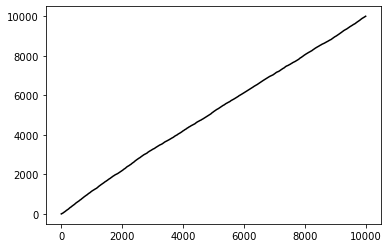

In [14]:
plt.plot(wp[0,:], wp[1,:], 'k')
# plt.plot(wp2[0,:], wp2[1,:], 'r')
# plt.plot(wp3[0,:], wp3[1,:], 'b')